<a href="https://colab.research.google.com/github/Karthik-Pandaram/Machine-learning-projects/blob/main/Signals_lstm_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character-level recurrent sequence-to-sequence model

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2017/09/29<br>
**Last modified:** 2020/04/26<br>
**Description:** Character-level recurrent sequence-to-sequence model.

## Introduction

This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.


## Setup


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


## Download the data


In [5]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip


['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

## Configuration


In [6]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"


## Prepare the data


In [47]:
#Change input text to sequences 
X = list()
Y = list()
X = [x for x in range(0, 1000, 1)]
Y = [y for y in range(1000, 0, -1)]

X = np.array(X).reshape(20, 50)
Y = np.array(Y).reshape(20, 50)
inwave = [ ]
tarwave = [ ]
for wav in X:
 inwave.append(np.array2string(wav,max_line_width=1000, precision=2, separator=',',
                      suppress_small=True,))
for wav in Y:
 tarwave.append(np.array2string(wav,max_line_width=1000, precision=2, separator=',',
                      suppress_small=True))

In [48]:
tarwave[10]

'[500,499,498,497,496,495,494,493,492,491,490,489,488,487,486,485,484,483,482,481,480,479,478,477,476,475,474,473,472,471,470,469,468,467,466,465,464,463,462,461,460,459,458,457,456,455,454,453,452,451]'

In [49]:
# Vectorize the data.
# inwave = []
# target_texts = []
input_characters = set()
target_characters = set()
# with open(data_path, "r", encoding="utf-8") as f:
#     lines = f.read().split("\n")
for line in inwave:
    # input_text, target_text, _ = line.split("\t")
    # # We use "tab" as the "start sequence" character
    # # for the targets, and "\n" as "end sequence" character.
    # target_text = "\t" + target_text + "\n"
    # input_texts.append(input_text)
    # target_texts.append(target_text)
    for char in line:
        if char not in input_characters:
            input_characters.add(char)
for line in tarwave:            
    for char in line:
        if char not in target_characters:
            target_characters.add(char)

In [50]:
input_characters

{' ', ',', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '[', ']'}

In [51]:
len(inwave)

20

Character encodind done ok!

In [52]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in inwave])
max_decoder_seq_length = max([len(txt) for txt in tarwave])

print("Number of samples:", len(inwave))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(inwave), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(inwave), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(inwave), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(inwave, tarwave)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 20
Number of unique input tokens: 14
Number of unique output tokens: 14
Max sequence length for inputs: 201
Max sequence length for outputs: 251


In [53]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])

In [54]:
encoder_input_data

array([[[0., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [55]:
inwave

['[ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49]',
 '[50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]',
 '[100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149]',
 '[150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199]',
 '[200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249]',
 '[250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266

## Build the model


In [56]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


## Train the model


Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 2.6249 - accuracy: 0.2263 - val_loss: 2.4087 - val_accuracy: 0.4462
Epoch 2/1000
1/1 [==============================] - 0s 231ms/step - loss: 2.4620 - accuracy: 0.3802 - val_loss: 2.1408 - val_accuracy: 0.3635
Epoch 3/1000
1/1 [==============================] - 0s 214ms/step - loss: 2.2053 - accuracy: 0.2918 - val_loss: 2.3424 - val_accuracy: 0.4173
Epoch 4/1000
1/1 [==============================] - 0s 215ms/step - loss: 2.3641 - accuracy: 0.3541 - val_loss: 2.5192 - val_accuracy: 0.3416
Epoch 5/1000
1/1 [==============================] - 0s 220ms/step - loss: 2.5530 - accuracy: 0.2761 - val_loss: 2.2367 - val_accuracy: 0.4472
Epoch 6/1000
1/1 [==============================] - 0s 210ms/step - loss: 2.3122 - accuracy: 0.3835 - val_loss: 2.1037 - val_accuracy: 0.4512
Epoch 7/1000
1/1 [==============================] - 0s 208ms/step - loss: 2.2160 - accuracy: 0.3884 - val_loss: 1.9339 - val_accuracy: 0.4343
Epoch 8/1

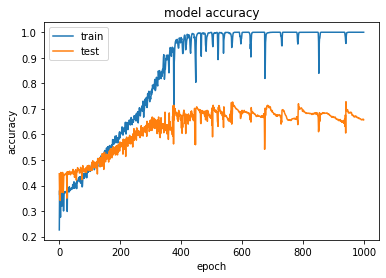

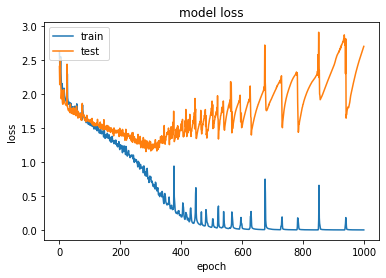

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


In [57]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=1000,
    validation_split=0.2,
)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Save model
model.save("s2s")


## Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [12]:
plt.savefig("plots.pdf")

<Figure size 432x288 with 0 Axes>

In [64]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["["]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = "["
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence



You can now generate decoded sentences as such:


In [59]:
inwave[1]

'[50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]'

In [60]:
tarwave[1]

'[950,949,948,947,946,945,944,943,942,941,940,939,938,937,936,935,934,933,932,931,930,929,928,927,926,925,924,923,922,921,920,919,918,917,916,915,914,913,912,911,910,909,908,907,906,905,904,903,902,901]'

In [80]:
for seq_index in range(2):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_signal = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", inwave[seq_index])
    print("Decoded sentence:", decoded_signal)


-
Input sentence: [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49]
Decoded sentence: [1000, 999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986, 985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958, 957, 956, 955, 954, 953, 952, 951] 
-
Input sentence: [50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]
Decoded sentence: [950,949,948,947,946,945,944,943,942,941,940,939,938,937,936,935,934,933,932,931,930,929,928,927,926,925,924,923,922,921,920,919,918,917,916,915,914,913,912,911,910,909,908,907,906,905,904,903,902,901]                                                   


# Post processing after inference to convert back to array 

In [81]:
decoded_signal.strip( )
decoded_signal = decoded_signal.replace('[','')
decoded_signal = decoded_signal.replace(']','')
output_signal = np.fromstring(decoded_signal, dtype=int, sep=',')

In [82]:
output_signal

array([950, 949, 948, 947, 946, 945, 944, 943, 942, 941, 940, 939, 938,
       937, 936, 935, 934, 933, 932, 931, 930, 929, 928, 927, 926, 925,
       924, 923, 922, 921, 920, 919, 918, 917, 916, 915, 914, 913, 912,
       911, 910, 909, 908, 907, 906, 905, 904, 903, 902, 901])